In [1]:
import pandas as pd
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [3]:
df = pd.read_csv("preprocessed_sentiment140.csv")
w2v = Word2Vec.load("word2vec.model")

In [4]:
df_train, df_test = train_test_split(df, test_size=1-0.8, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 594849


In [6]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)

In [7]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [8]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [9]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v.wv:
    embedding_matrix[i] = w2v.wv[word]
print(embedding_matrix.shape)

(594849, 300)


In [10]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [11]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          178454700 
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 178615201 (681.36 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 178454700 (680.75 MB)
_________________________________________________________________


In [13]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [14]:
history = model.fit(x_train, y_train,
                             batch_size=1024,
                             epochs=8,
                             validation_split=0.1,
                             verbose=1,
                             callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - 32749s 29s/step - loss: 0.5249 - accuracy: 0.7363 - val_loss: 0.4699 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 2/8
1125/1125 [==============================] - 38862s 35s/step - loss: 0.4853 - accuracy: 0.7644 - val_loss: 0.4607 - val_accuracy: 0.7848 - lr: 0.0010
Epoch 3/8
1125/1125 [==============================] - 40328s 36s/step - loss: 0.4758 - accuracy: 0.7703 - val_loss: 0.4532 - val_accuracy: 0.7890 - lr: 0.0010
Epoch 4/8
1125/1125 [==============================] - 40383s 36s/step - loss: 0.4701 - accuracy: 0.7739 - val_loss: 0.4513 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 5/8
1125/1125 [==============================] - 43479s 39s/step - loss: 0.4658 - accuracy: 0.7763 - val_loss: 0.4456 - val_accuracy: 0.7929 - lr: 0.0010
Epoch 6/8
1125/1125 [==============================] - 44453s 40s/step - loss: 0.4631 - accuracy: 0.7781 - val_loss: 0.4431 - val_accuracy: 0.7941 - lr: 0.0010
Epoch 7/8
1125/1125 [===================

In [16]:
score = model.evaluate(x_test, y_test, batch_size=1024)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 1097s 3s/step - loss: 0.4391 - accuracy: 0.7958

ACCURACY: 0.7958031296730042
LOSS: 0.4391280710697174


In [17]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = 'NEUTRAL'
        if score <= 0.4:
            label = 'NEGATIVE'
        elif score >= 0.7:
            label = 'POSITIVE'

        return label
    else:
        return 'NEGATIVE' if score < 0.5 else 'POSITIVE'

In [19]:
import time
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [20]:
predict("I love the music")

1/1 [==============================] - 1s 772ms/step


{'label': 'POSITIVE',
 'score': 0.9872039556503296,
 'elapsed_time': 0.9433302879333496}

In [21]:
predict("I hate the rain")

1/1 [==============================] - 0s 119ms/step


{'label': 'NEGATIVE',
 'score': 0.00890456885099411,
 'elapsed_time': 0.18699312210083008}

In [22]:
predict("i don't know what i'm doing")

1/1 [==============================] - 0s 116ms/step


{'label': 'NEGATIVE',
 'score': 0.193094402551651,
 'elapsed_time': 0.19300007820129395}

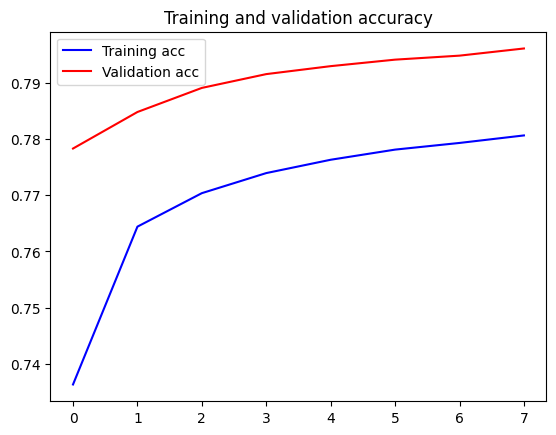

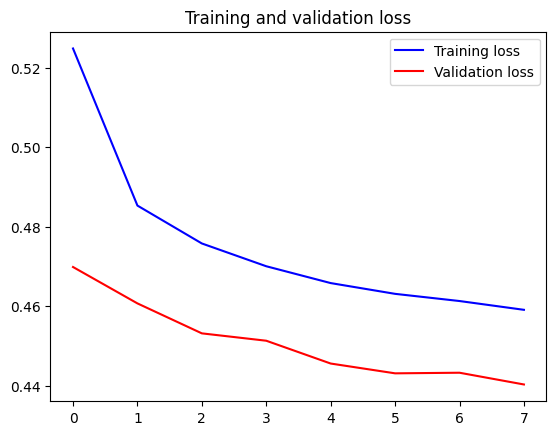

In [25]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [35]:
import pickle
model.save('model.h5')
pickle.dump(tokenizer, open("tokenizer.pkl", "wb"), protocol=0)
pickle.dump(encoder, open("encoder.pkl", "wb"), protocol=0)

C:\Users\theat\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
model.save('keras_model.keras')